In [22]:
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

## Чтение данных

In [2]:
data = pd.read_csv('../data/data.csv')
data = data.drop(columns=[
    "oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1",
    "g0", "g1", "coeff_sum0", "coeff_sum1"])
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


In [3]:
data["date_time"] = pd.to_datetime(data["date_time"])
data["date_time"].min(), data["date_time"].max()

(Timestamp('2021-09-01 00:02:49'), Timestamp('2021-10-02 23:59:59'))

In [4]:
last_date = data["date_time"].max().date()
mask = data["date_time"].dt.date == last_date
test_frac = mask.sum() / len(data)
print(f"Последнему дню соответствует {test_frac*100:.1f}% данных")

Последнему дню соответствует 13.5% данных


In [5]:
df = data[~mask]
df_test = data[mask]
print(df.shape, df_test.shape)

(13692494, 8) (2128978, 8)


## Визуализация данных

In [6]:
def plot_counts_mean(df: pd.DataFrame, col_name: str):
    grouped = df[[col_name, "clicks"]].groupby(col_name)
    x = list(grouped.groups.keys())
    counts = grouped.size()
    means = grouped.mean()

    plt.figure(figsize=(6, 6))
    plt.subplot(211)
    plt.semilogy(counts.index, counts.values, color="tab:blue")
    plt.ylabel("Counts")
    plt.subplot(212)
    plt.plot(means.index, means.values, color="tab:orange")
    plt.ylabel("Avg. clicks")
    plt.xlabel(col_name)
    plt.tight_layout()
    plt.show()

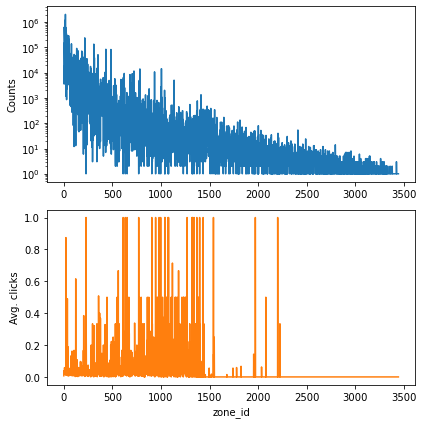

In [7]:
plot_counts_mean(df, "zone_id")

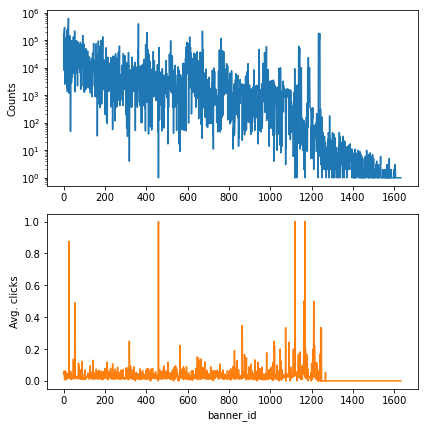

In [8]:
plot_counts_mean(df, "banner_id")

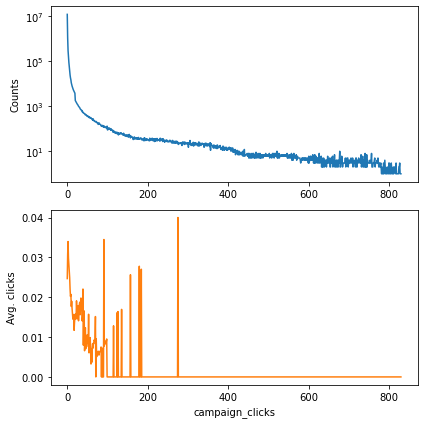

In [9]:
plot_counts_mean(df, "campaign_clicks")

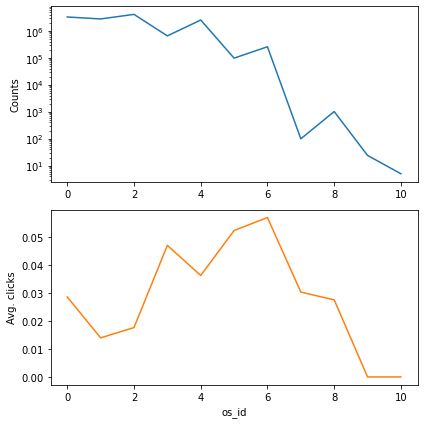

In [10]:
plot_counts_mean(df, "os_id")

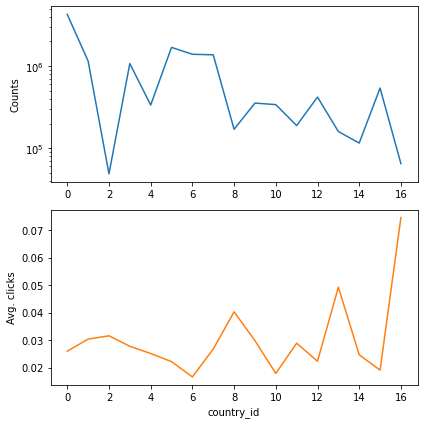

In [11]:
plot_counts_mean(df, "country_id")

In [12]:
pd.unique(df["impressions"])

array([1])

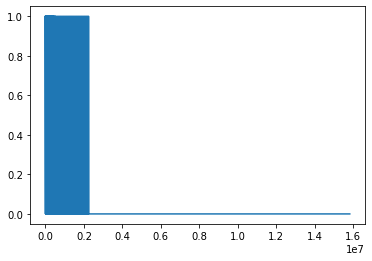

In [13]:
plt.plot(df["clicks"])

## Выбор признаков

In [19]:
def process_data(df: pd.DataFrame, drop_ids: bool = True) -> pd.DataFrame:
    df_new = deepcopy(df)
    df_new.drop("impressions", axis=1, inplace=True)
    process_date_time(df_new)
    process_os_id(df_new, n=7)
    process_country_id(df_new, n=16)
    process_campaign_clicks(df_new)
    if drop_ids:
        df_new.drop(columns=["zone_id", "banner_id"], inplace=True)
    return df_new

# all following functions modify dataframe inplace
def process_date_time(df: pd.DataFrame) -> None:
    df["weekday"] = df["date_time"].dt.weekday
    df["hour"] = df["date_time"].dt.hour
    df.drop("date_time", axis=1, inplace=True)

def process_os_id(df: pd.DataFrame, n: int) -> None:
    one_hot_n_first(df, "os_id", n=n)

def process_country_id(df: pd.DataFrame, n: int) -> None:
    one_hot_n_first(df, "country_id", n=n)

def one_hot_n_first(df: pd.DataFrame, col_name: str, n: None | int) -> None:
    if n is not None:
        mask = df[col_name] >= n
        df.loc[mask, col_name] = n
    dummies = pd.get_dummies(df[col_name])
    if n is None:
        n = dummies.shape[1] - 1
    col_names = [f"{col_name}_{i}" for i in range(n + 1)]
    df[col_names] = dummies
    df.drop(col_name, axis=1, inplace=True)

def process_campaign_clicks(df: pd.DataFrame) -> None:
    df["log_campaign_clicks"] = np.log(df["campaign_clicks"] + 1)
    df.drop("campaign_clicks", axis=1, inplace=True)

In [20]:
df_p = process_data(df)
df_p.head()

,clicks,weekday,hour,os_id_0,os_id_1,os_id_2,os_id_3,os_id_4,os_id_5,os_id_6,...,country_id_8,country_id_9,country_id_10,country_id_11,country_id_12,country_id_13,country_id_14,country_id_15,country_id_16,log_campaign_clicks
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,1,6,22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,1,6,23,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.386294
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [21]:
df_test_p = process_data(df_test)
df_test_p.head()

,clicks,weekday,hour,os_id_0,os_id_1,os_id_2,os_id_3,os_id_4,os_id_5,os_id_6,...,country_id_8,country_id_9,country_id_10,country_id_11,country_id_12,country_id_13,country_id_14,country_id_15,country_id_16,log_campaign_clicks
164,1,5,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
166,1,5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
168,1,5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
169,1,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
359,1,5,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


## Линейная модель

In [25]:
N_SPLITS = 5
N_C = 6
X = df_p.drop("clicks", axis=1).to_numpy()
y = df_p["clicks"].to_numpy()

skf = StratifiedKFold(N_SPLITS)
c_vals = np.logspace(-4, 4, N_C)
train_losses = np.zeros((N_C, N_SPLITS))
val_losses = np.zeros_like(train_losses)

for i, ci in enumerate(c_vals):
    model = LogisticRegression(solver="liblinear", C=ci)

    for j, (train_index, val_index) in tqdm(enumerate(skf.split(X, y))):
        model.fit(X[train_index], y[train_index])

        pred_train = model.predict_proba(X[train_index])[:, 1]
        train_loss = log_loss(y[train_index], pred_train)
        pred_val = model.predict_proba(X[val_index])[:, 1]
        val_loss = log_loss(y[val_index], pred_val)

        train_losses[i, j] = train_loss
        val_losses[i, j] = val_loss

    print(f"C = {ci:.2e}, train_loss = {train_losses[i].mean():.2e}, " +
          f"val_loss = {val_losses[i].mean():.2e}")

5it [01:06, 13.29s/it]
0it [00:00, ?it/s]

C = 1.00e-04, train_loss = 1.16e-01, val_loss = 1.20e-01


5it [01:20, 16.17s/it]
0it [00:00, ?it/s]

C = 3.98e-03, train_loss = 1.15e-01, val_loss = 1.21e-01


5it [01:29, 17.82s/it]
0it [00:00, ?it/s]

C = 1.58e-01, train_loss = 1.15e-01, val_loss = 1.21e-01


5it [01:30, 18.12s/it]
0it [00:00, ?it/s]

C = 6.31e+00, train_loss = 1.15e-01, val_loss = 1.21e-01


5it [01:33, 18.65s/it]
0it [00:00, ?it/s]

C = 2.51e+02, train_loss = 1.15e-01, val_loss = 1.21e-01


5it [01:34, 18.90s/it]

C = 1.00e+04, train_loss = 1.15e-01, val_loss = 1.21e-01


In [26]:
model = LogisticRegression(solver="liblinear", C=10.0)
model.fit(X, y)
pred_train = model.predict_proba(X)[:, 1]
pred_train

array([0.02309828, 0.04068747, 0.03465127, ..., 0.00962696, 0.02429376,
       0.02452088])

In [27]:
log_loss(y, pred_train)

0.1153117297944636

In [28]:
avg_clicks = y.mean()
avg_clicks

0.025334099105685202

In [33]:
log_loss(y, np.full(y.shape, avg_clicks))

0.11812856199302779

In [34]:
X_test = df_test_p.drop("clicks", axis=1).to_numpy()
y_test = df_test_p["clicks"].to_numpy()
pred_test = model.predict_proba(X_test)[:, 1]
log_loss(y_test, pred_test)

0.1481009387237664

In [35]:
log_loss(y_test, np.full(y_test.shape, avg_clicks))

0.15486198009919555